In [1]:
# ---------------------------
# 1. SETUP AND FILE UPLOAD
# ---------------------------
# Installing the required library for interactive widgets in Jupyter.
!pip install ipywidgets


In [3]:
from ipywidgets import FileUpload

# Define a function to read content from uploaded files. This is useful for later extracting the data 
# once users have uploaded it using the widget.
def read_uploaded_file(upload):
    ''' Reads the content of an uploaded file into a string '''
    for name, file_info in upload.value.items():
        return file_info['content'].decode('utf-8')


# Create widgets for users to upload training and testing data.
# This provides an interface in Jupyter for users to interactively upload their data.

train_upload = FileUpload(accept='.txt', multiple=False, description='Upload train.txt')
test_upload = FileUpload(accept='.txt', multiple=False, description='Upload test.txt')

display(train_upload)
display(test_upload)


FileUpload(value={}, accept='.txt', description='Upload train.txt')

FileUpload(value={}, accept='.txt', description='Upload test.txt')

In [4]:

# Read the uploaded training and testing data
train_data_uploaded = read_uploaded_file(train_upload)
test_data_uploaded = read_uploaded_file(test_upload)
# A quick check to ensure the file is uploaded correctly by printing the first few characters.
print(train_data_uploaded[:100])


[Open to Morty’s room]
Rick: (stumbles in drunkenly, and turns on the lights) Morty! You gotta come


In [5]:
# Install the Transformers library
!pip install transformers


In [6]:

# ---------------------------
# 2. PREPROCESSING AND TOKENIZATION
# ---------------------------
# Installing the HuggingFace Transformers library.
# This library is vital for using pre-trained transformer models like GPT-2.

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, random_split

# This seed is set to ensure reproducibility. It makes sure that every run of the code yields the same result.

torch.manual_seed(0)
# Initializing the tokenizer for the GPT-2 model.
model_name = 'distilgpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [7]:

# Divide the large text into manageable chunks. This makes it easier to process and train on the data.

chunk_size = 200  
chunks_train = [train_data_uploaded[i:i + chunk_size] for i in range(0, len(train_data_uploaded), chunk_size)]
chunks_test = [test_data_uploaded[i:i + chunk_size] for i in range(0, len(test_data_uploaded), chunk_size)]


In [8]:


# Custom dataset to handle our tokenized sequences. It ensures each data point is of the same size and is tokenized correctly.

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, chunks, tokenizer, max_length=220):
        self.tokenized_data = [tokenizer(chunk, truncation=True, padding='max_length', max_length=max_length, return_tensors="pt") for chunk in chunks]
        self.input_ids = [item['input_ids'][0] for item in self.tokenized_data]
        self.attention_mask = [item['attention_mask'][0] for item in self.tokenized_data]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx]
        }



In [9]:
# Convert the chunks into datasets ready for training and testing.
train_dataset = CustomDataset(chunks_train, tokenizer)
test_dataset = CustomDataset(chunks_test, tokenizer)


# We're splitting the training dataset into training and validation subsets. 
# This helps in monitoring and preventing overfitting.
train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# DataLoaders help in batching and shuffling the data. This makes the training process more efficient.

train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ---------------------------
# 3. MODEL SETUP AND TRAINING
# ---------------------------
# Initializing the GPT-2 model for training and setting up its optimizer.
model = GPT2LMHeadModel.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))
optimizer = AdamW(model.parameters(), lr=5e-5)

# The learning rate scheduler allows for optimization of training by gradually decreasing the learning rate over epochs.

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 3)  # Assuming 3 epochs



C:\Users\HP\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
import time

# Fine-tuning loop
# Moving the model to GPU if available for faster computation.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to keep track of losses during training.
losses = []
val_losses = []

# Actual training loop. This is where the model learns from the data.
for epoch in range(3):  # You can adjust the number of epochs
    model.train()
    total_loss = 0.0
    
    start_time = time.time()  # start timing for the epoch

    for batch_idx, batch in enumerate(train_loader):
        batch_start_time = time.time()  # start timing for the batch

        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = inputs.clone()
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # compute time taken for the batch and project for the entire epoch
        batch_end_time = time.time()
        elapsed_time = batch_end_time - batch_start_time
        eta = (len(train_loader) - batch_idx - 1) * elapsed_time
        print(f"Epoch {epoch + 1} | Batch {batch_idx + 1}/{len(train_loader)} | Batch Time: {elapsed_time:.2f} seconds | ETA for Epoch: {eta:.2f} seconds", end='\r')  # use end='\r' to overwrite the line in the console
        
    epoch_end_time = time.time()
    avg_train_loss = total_loss / len(train_loader)
    losses.append(avg_train_loss)
    
    print(f"\nEpoch {epoch + 1}/{3} - Training Loss: {avg_train_loss} | Total Epoch Time: {epoch_end_time - start_time:.2f} seconds")
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = inputs.clone()
            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{3} - Validation Loss: {avg_val_loss}")


Epoch 1 | Batch 275/275 | Batch Time: 8.92 seconds | ETA for Epoch: 0.00 secondsdsss
Epoch 1/3 - Training Loss: 1.627066073851152 | Total Epoch Time: 2924.65 seconds
Epoch 1/3 - Validation Loss: 1.0977593952295732
Epoch 2 | Batch 275/275 | Batch Time: 8.89 seconds | ETA for Epoch: 0.00 secondsdsss
Epoch 2/3 - Training Loss: 1.097636061364954 | Total Epoch Time: 2796.27 seconds
Epoch 2/3 - Validation Loss: 1.0395951514341393
Epoch 3 | Batch 275/275 | Batch Time: 8.99 seconds | ETA for Epoch: 0.00 secondsdsss
Epoch 3/3 - Training Loss: 1.050896923975511 | Total Epoch Time: 2807.72 seconds
Epoch 3/3 - Validation Loss: 1.025669159937878


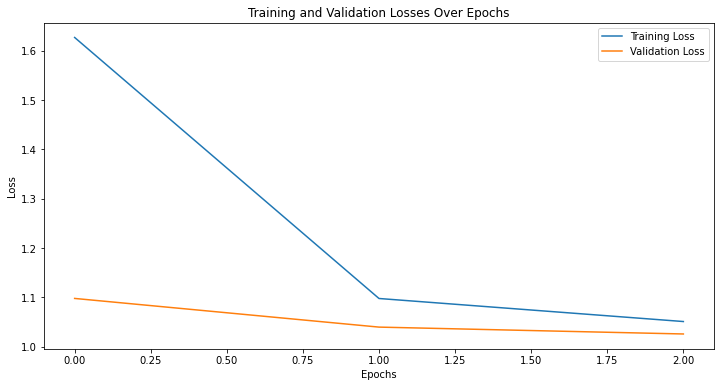

In [11]:
import matplotlib.pyplot as plt

# Plotting the training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.show()


In [12]:
# 4. EVALUATION AND GENERATION
# ---------------------------
# Evaluation of the model on the test dataset to measure its performance.
model.eval()

total_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = inputs.clone()
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        total_loss += outputs.loss.item()

avg_loss = total_loss / len(test_loader)
perplexity = torch.exp(torch.tensor(avg_loss))

print(f"Test Loss: {avg_loss:.4f}")
print(f"Perplexity: {perplexity:.4f}")


Test Loss: 1.1296
Perplexity: 3.0945


In [13]:
#Save the Fine-tuned Model
model_save_name = "fine_tuned_gpt2.pt"
model_path = F"./{model_save_name}"
torch.save(model.state_dict(), model_path)


In [18]:
# Generating new text based on a given prompt. This shows the model's capability post-training.
model.eval()

prompt_text = "Once upon a time"  # Or any starting string as per user's choice 
prompt = tokenizer.encode(prompt_text, return_tensors="pt").to(device)
sample_output = model.generate(prompt, max_length=100, num_return_sequences=5, num_beams=5, top_k=50, temperature=0.7, pad_token_id=tokenizer.eos_token_id)

print("Generated Stories:")
for i, output in enumerate(sample_output):
    decoded_output = tokenizer.decode(output, skip_special_tokens=True)
    print(f"\nStory {i + 1}:\n{decoded_output}")


Generated Stories:

Story 1:
Once upon a time, I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot

Story 2:
Once upon a time, I’m not a robot. I’m a robot. I’m a robot. I’m a robot. I’m a robot. I’m a robot. I’m a robot. I’m a robot. I’m a robot. I’m a robot. I’m a robot. I’m a robot. I’m a robot. I’

Story 3:
Once upon a time, I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m a robot.

Story 4:
Once upon a time, I’m not a robot. I’m not a robot. I’m a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot. I’m not a robot.

Story 5:
Once upon a time, I’m not a robot. I’m not a robot. I’m not a robot. I’m not a r